In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Задание
- Посчитать tpr и fpr в ноутбуке к лекции. Убедиться, что график ROC AUC получается таким же, как и штатными средствами

- Потроить график Precision - Recall на этих же данных

# Решение

Загрузим данные, они содержат признаки пользователей и целевую переменную affair - была ли связь на стороне

In [ ]:
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [ ]:
y = data['affair']
X = data[data.columns[:-1]]

Разбиваем данные на обучающую и тестовую выборки в соотношении 70 / 30

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Обучаем модель

In [ ]:
model = LogisticRegression().fit(X_train, Y_train)
# Вероятности классов и предсказанные классы на тестовых данных
predictions = model.predict_proba( X_test )
predict = model.predict( X_test )

Вручную рассчитаем метрики Accuracy, Precision, Recall для порога = 0.5

In [ ]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

for predicted_prob, actual in zip( predictions[:, 1], Y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [ ]:
# какая точность получилась?
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [ ]:
# выведем значения
print(f"Accuracy (score) = {accuracy:.5f}")
print(f"Precision = {precision:.5f}")
print(f"Recall = {recall:.5f}")

Accuracy (score) = 0.73194
Precision = 0.63305
Recall = 0.37232


In [ ]:
# То же самое - штатными средствами: импортируем функции для метрик и рассчитаем
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"Accuracy (score) = {accuracy_score(Y_test, predict):.5f}")
print(f"Precision = {precision_score(Y_test, predict):.5f}")
print(f"Recall = {recall_score(Y_test, predict):.5f}")

Accuracy (score) = 0.73194
Precision = 0.63305
Recall = 0.37232


Резюме: как видим - метрики совпадают

# ROC-кривая и кривая Precision - Recall

Построим указанные кривые по данным, рассчитанным вручную и штатными средствами

In [ ]:
# Определяем функцию, которая будет выдавать Precision, Recall (TPR), FPR для заданного порога
def hand_metrics_from_threshold(y_actual, y_predict_proba, threshold):
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    for predicted_prob, actual in zip( y_predict_proba, y_actual ):    
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0
        
        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    precision = tp / (tp + fp)
    tpr_recall = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return precision, tpr_recall, fpr

In [ ]:
# Определяем функцию, которая отдает массивы Precision, Recall(TPR), FPR для массива порогов
def hand_metrics(y_actual, y_pred_proba, threshold):
    y_pred_proba = y_pred_proba[:, 1]
    pr, tpr, fpr = [], [], []
    
    for thres in threshold:
      pr_,tpr_,fpr_ = hand_metrics_from_threshold(y_actual, y_pred_proba, thres)
      pr.append(pr_)
      tpr.append(tpr_)
      fpr.append(fpr_)
    return pr,tpr,fpr

Зададим несколько точек для порога - не очень много, чтобы сравнить на графике с "эталоном" - от максимального значения вероятности класса "1" до минимального:

In [ ]:
# Значения для порога - 25 точек
thres = np.linspace(np.max(predictions[:,1]),np.min(predictions[:,1]),25)

In [ ]:
# Рассчитаем метрики без использования библиотек:
pr, tpr_rec, fpr = hand_metrics(Y_test, predictions, thres)

In [ ]:
# ..И используя штатные средства - функцию sklearn
from sklearn.metrics import precision_recall_curve
pr_state, tpr_rec_state, thres = precision_recall_curve( Y_test, predictions[:,1] )

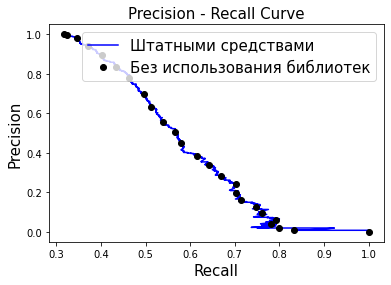

In [321]:
# Отобразим на графике кривую Precision - Recall
plt.plot( pr_state, tpr_rec_state, 'b', label='Штатными средствами')
plt.plot( pr, tpr_rec, 'ko' , label='Без использования библиотек')

plt.title('Precision - Recall Curve', fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.legend(fontsize=15, loc=1)

Точно так же построим ROC-кривую - для рассчетов без использования библиотек и штатными методами

In [323]:
# значения false и true positive rate для различных значений порога
from sklearn.metrics import roc_curve
fpr_state, tpr_state, thres = roc_curve( Y_test, model.predict_proba(X_test)[:, 1] )

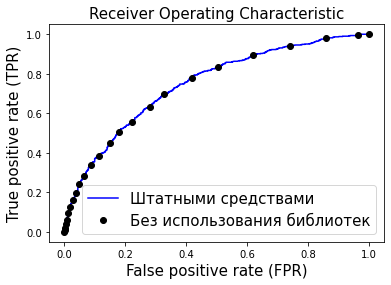

In [325]:
# Отобразим на графике кривую ROC
plt.plot( fpr_state, tpr_state, 'b', label='Штатными средствами')
plt.plot( fpr, tpr_rec, 'ko' , label='Без использования библиотек')

plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15, loc=0)

Мы убедились, что кривая Precision - Recall и ROC-кривая выглядят аналогично для случая использования штатных функций sklearn и для рассчета этих метрик без использования библиотек, что отражает понимание что из себя представляют данные метрики, как рассчитываются и какую значимость имеет порог отсечения одного класса от другого.
Задача выполнена.